# Person re-identification 

### This sample use simple pretrained resnet-152 model to extract features/embeddings for an image 

### Compute Embedding

In [96]:
import sys
import os
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
sys.path.append(os.path.abspath('./src'))
from resnetembedding import ResnetEmbedder

In [3]:
def embed(image_path):
    image = io.imread(image_path)
    embedder = ResnetEmbedder()
    return embedder(image).data.numpy()


In [4]:

images_to_embed = [
    ["tests/imagesCaviar/0001007.jpg",
     "tests/imagesCaviar/0001008.jpg",
     "tests/imagesCaviar/0001009.jpg",
     "tests/imagesCaviar/0001010.jpg"],
    ["tests/imagesCaviar/0002001.jpg",
     "tests/imagesCaviar/0002002.jpg",
     "tests/imagesCaviar/0002003.jpg",
     "tests/imagesCaviar/0002004.jpg"],
    ['tests/imagesLFW/AJ_Cook_001.jpg'],
    ['tests/imagesLFW/George_W_Bush_0517.jpg',
     'tests/imagesLFW/George_W_Bush_0518.jpg']
]

embeddings = []
class_person=[]
for e, persons in enumerate(images_to_embed):
    for person_img in persons:
        embeddings.append(  embed(person_img)[0])
        class_person.append(e)

embeddings = np.stack( embeddings)


### Compute pairwise distance

In [27]:
from EuclideanPairwiseDistance import EuclideanPairwiseDistance

distance_metric = EuclideanPairwiseDistance()
pairwise_distance = distance_metric(torch.tensor(embeddings))
pairwise_distance

tensor([[ 0.0000, 55.1163, 55.3310, 55.5862, 51.5287, 61.8887, 57.1199, 67.6788,
         88.4629, 78.0813, 74.8508],
        [55.1163,  0.0000, 23.9353, 23.0195, 53.8990, 71.4051, 63.6156, 79.4457,
         77.7730, 75.0156, 75.8787],
        [55.3310, 23.9353,  0.0000, 19.7439, 49.4162, 68.4724, 62.0006, 79.4011,
         83.7693, 79.8911, 80.5265],
        [55.5862, 23.0195, 19.7439,  0.0000, 49.5838, 67.2909, 61.3300, 78.8069,
         78.3274, 76.2247, 77.1119],
        [51.5287, 53.8990, 49.4162, 49.5838,  0.0000, 35.6241, 40.1188, 54.9345,
         84.7086, 73.9627, 73.6753],
        [61.8887, 71.4051, 68.4724, 67.2909, 35.6241,  0.0000, 45.7990, 46.8281,
         95.8567, 83.0496, 81.7522],
        [57.1199, 63.6156, 62.0006, 61.3300, 40.1188, 45.7990,  0.0000, 44.0803,
         81.6414, 68.4018, 66.9947],
        [67.6788, 79.4457, 79.4011, 78.8069, 54.9345, 46.8281, 44.0803,  0.0000,
         92.3140, 77.8021, 78.9501],
        [88.4629, 77.7730, 83.7693, 78.3274, 84.7086, 95

### Compute CMC score
Definition: https://www.nist.gov/sites/default/files/documents/2016/12/06/12_ross_cmc-roc_ibpc2016.pdf

* Each sample is  compared against all gallery samples. The resulting scores are sorted and ranked

* Determine the rank at which a true match occurs 
* True Positive Identification Rate (TPIR): Probability of observing the correct identity within the top K ranks
* CMC Curve: Plots TPIR against ranks
* CMC Curve: Rank based metric



In [93]:


def accuracy_at_top_k(pairwise_distance_matrix, k, target_label):
    #Get the index matrix of the top k nearest neighbours
    rank_k = torch.topk(pairwise_distance,k=k+1, dim=1, largest = False)[1]

    #Ignore rank 0, as they are the same elements ( diagonal)
    rank_k = rank_k[:, 1:]
    
    #map item index to target class
    map_id_to_class = lambda x: target_label[x]
    map_id_to_class_vec = np.vectorize(map_id_to_class)
    rank_k_label = map_id_to_class_vec(rank_k)

    #Compute accuracy
    correct = 0
    for i, r in enumerate(rank_k_label):
        if target_label[i] in r : correct+=1

    accuracy = (correct*100.0)/len(target_label)
    
    return accuracy, rank_k_label


    


In [94]:
k=2
accuracy, rank_k_label = accuracy_at_top_k(pairwise_distance, k, class_person)
print("Percentage accuracy at k = {} is {}".format(k, accuracy ))

Percentage accuracy at k = 2 is 90.9090909090909


In [101]:
result_df = pd.DataFrame(rank_k_label, columns= ["k_{}".format(i) for i in range(k)])
result_df["actual"] = class_person

In [103]:
result_df.head(n=20)

,k_0,k_1,actual
0,1,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,1,1,1
5,1,1,1
6,1,1,1
7,1,1,1
8,3,3,2
9,3,2,3


### Visualise the embeddings extracted using T-SNE

In [1]:
!pip install scikit-learn==0.21.2

In [21]:
from sklearn.manifold import TSNE
embedding_tsne = TSNE(random_state=42).fit_transform(embeddings)

print("embeddings reduced to 2-D using TSNE\n")
print(embedding_tsne[0:10])

embeddings reduced to 2-D using TSNE

[[ 112.37329   -145.54024  ]
 [ 120.38639     61.33669  ]
 [  68.58103    -45.88331  ]
 [ -82.93789    100.80529  ]
 [   0.5197888 -165.20583  ]
 [  35.917812   139.61531  ]
 [-115.78925   -125.89123  ]
 [ 177.47624    -38.78004  ]
 [   3.9776573   35.23945  ]
 [ -31.471674   -59.34523  ]]


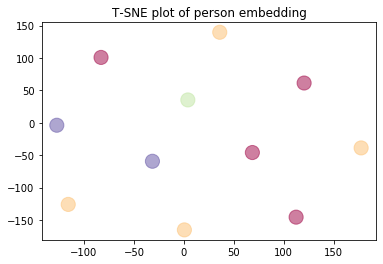

In [22]:
group = list(set(class_person))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

scatter = ax.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c= class_person, alpha=0.5, s= 200, cmap="Spectral" )

plt.title('T-SNE plot of person embedding')
plt.show()